In [22]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# read all words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [24]:
len(words)

32033

Vocab

In [25]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Dataset

In [26]:
block_size = 3

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


MLP params

In [27]:
n_embed = 10 #embedding dimensions
n_hidden = 200 #no of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total no of params
for p in parameters:
    p.requires_grad = True

11897


Optimization

In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 28.3854
  10000/ 200000: 2.9017
  20000/ 200000: 2.8037
  30000/ 200000: 2.2280
  40000/ 200000: 2.2751
  50000/ 200000: 1.9326
  60000/ 200000: 2.0983
  70000/ 200000: 2.5733
  80000/ 200000: 2.2635
  90000/ 200000: 1.9386
 100000/ 200000: 2.2774
 110000/ 200000: 2.2714
 120000/ 200000: 2.0092
 130000/ 200000: 2.1780
 140000/ 200000: 1.9868
 150000/ 200000: 2.2185
 160000/ 200000: 2.1936
 170000/ 200000: 1.9674
 180000/ 200000: 2.3236
 190000/ 200000: 2.1893


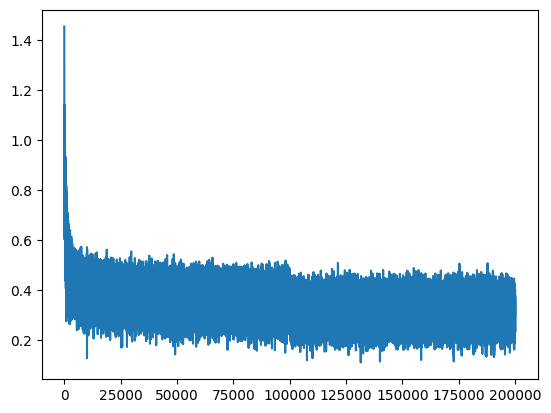

In [29]:
plt.plot(lossi)

Eval

In [30]:
@torch.no_grad() #disable grad tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embed)
    h = torch.tanh(embcat@ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.121068239212036
val 2.1569983959198


Sample from the model

In [31]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        #sample from the dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        #shift the context window
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


anuelen.
tia.
marian.
dante.
naysia.
yana.
kemah.
lani.
sepiaciolaniamiy.
kence.
jordigh.
alla.
mikolynn.
acvisia.
acarlin.
tian.
tiyan.
mar.
tal.
jena.


Improve Initialization

- Initial pred should be a uniform dist, all chars equally likely

In [32]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

- if logits are close to zero, loss will be lower, here logits are taking large values in first forward pass

- Squish W2 and b2 during initialization to reduce the intial loss

In [36]:
n_embed = 10 #embedding dimensions
n_hidden = 200 #no of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total no of params
for p in parameters:
    p.requires_grad = True

11897


In [34]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3047
  10000/ 200000: 2.4418
  20000/ 200000: 2.6091
  30000/ 200000: 2.2466
  40000/ 200000: 2.2464
  50000/ 200000: 1.8980
  60000/ 200000: 2.0689
  70000/ 200000: 2.4104
  80000/ 200000: 2.3587
  90000/ 200000: 1.9107
 100000/ 200000: 2.1966
 110000/ 200000: 2.1855
 120000/ 200000: 2.0407
 130000/ 200000: 2.1221
 140000/ 200000: 1.9044
 150000/ 200000: 2.2478
 160000/ 200000: 2.1897
 170000/ 200000: 1.8080
 180000/ 200000: 2.3101
 190000/ 200000: 1.9582


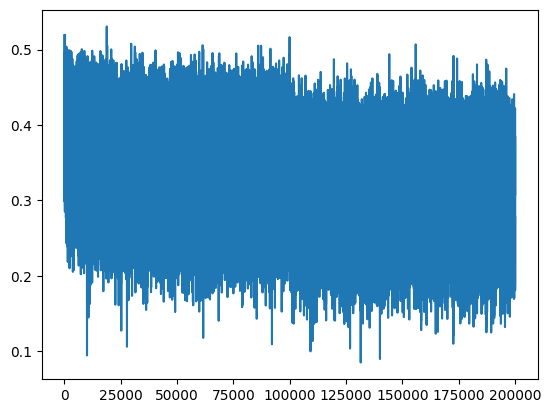

In [35]:
plt.plot(lossi)

In [37]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3047


In [38]:
h

tensor([[ 0.9987, -1.0000, -0.8266,  ...,  0.9944, -0.9998,  0.9962],
        [ 0.9996,  0.9955,  0.9998,  ..., -0.5337,  0.9991,  1.0000],
        [ 0.9432,  0.9971, -0.9997,  ...,  0.9999,  0.9626,  0.9992],
        ...,
        [-1.0000,  1.0000, -0.9991,  ..., -1.0000, -0.9742,  0.3958],
        [-1.0000,  1.0000, -1.0000,  ...,  0.9994,  0.9904,  0.9942],
        [ 1.0000,  1.0000, -0.9357,  ..., -1.0000, -0.9998, -1.0000]],
       grad_fn=<TanhBackward0>)

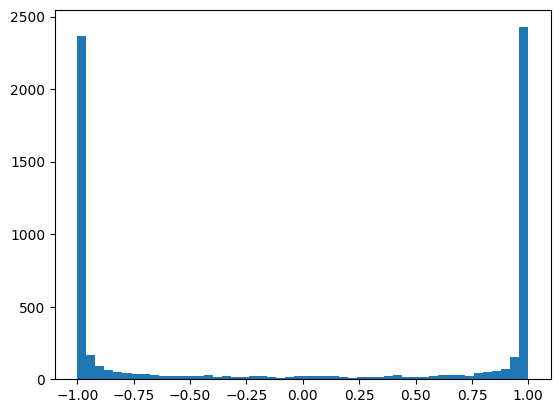

In [44]:
plt.hist(h.view(-1).tolist(), 50);

- Lot of h is here 1 or -1; h is the output of tanh

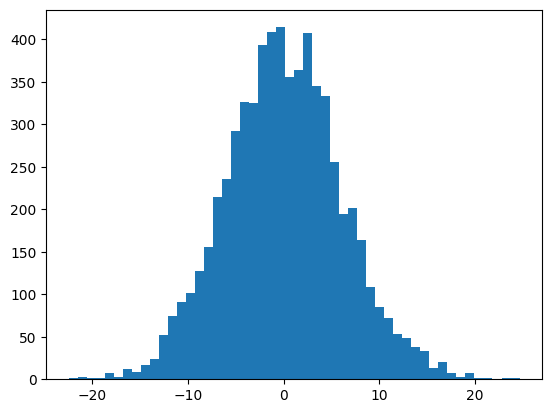

In [46]:
plt.hist(h_pre_act.view(-1).tolist(), 50);

- if tanh is 1 or -1, grad is killed and propagated back from there

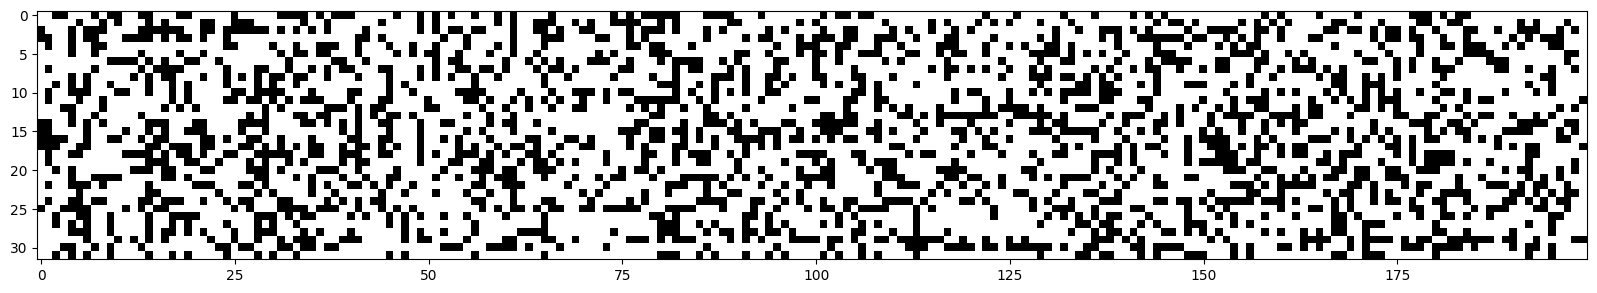

In [48]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- Since h_pre_act values are very large tanh out becomes 1 or -1
- So init W1 and b1 to be smaller as well

In [54]:
n_embed = 10 #embedding dimensions
n_hidden = 200 #no of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total no of params
for p in parameters:
    p.requires_grad = True

11897


In [55]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2930


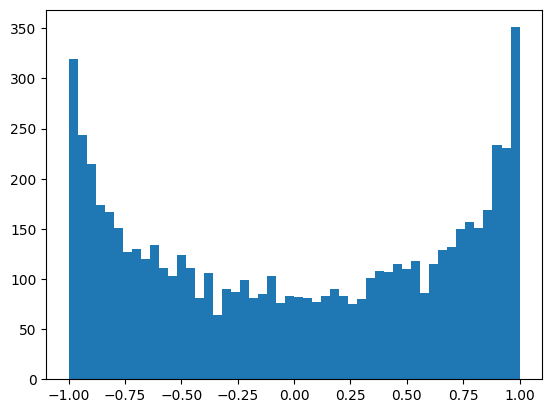

In [56]:
plt.hist(h.view(-1).tolist(), 50);

- Lot of h is here 1 or -1; h is the output of tanh

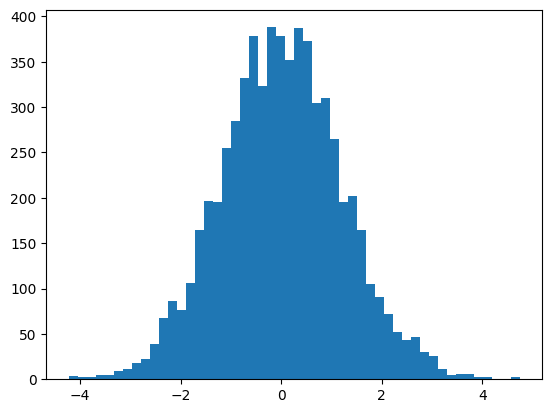

In [57]:
plt.hist(h_pre_act.view(-1).tolist(), 50);

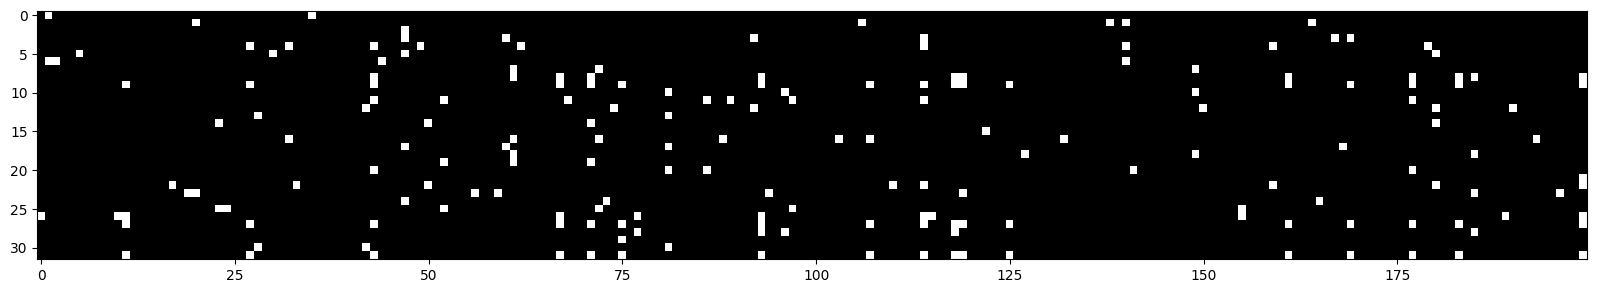

In [58]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [59]:
n_embed = 10 #embedding dimensions
n_hidden = 200 #no of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total no of params
for p in parameters:
    p.requires_grad = True

11897


In [61]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2689
  10000/ 200000: 1.8909
  20000/ 200000: 2.0036
  30000/ 200000: 2.2682
  40000/ 200000: 2.2862
  50000/ 200000: 2.3618
  60000/ 200000: 2.1527
  70000/ 200000: 2.4043
  80000/ 200000: 2.1908
  90000/ 200000: 2.4607
 100000/ 200000: 2.1866
 110000/ 200000: 1.9712
 120000/ 200000: 2.0890
 130000/ 200000: 2.3485
 140000/ 200000: 1.9912
 150000/ 200000: 2.1793
 160000/ 200000: 2.1190
 170000/ 200000: 1.9717
 180000/ 200000: 1.9458
 190000/ 200000: 2.0249


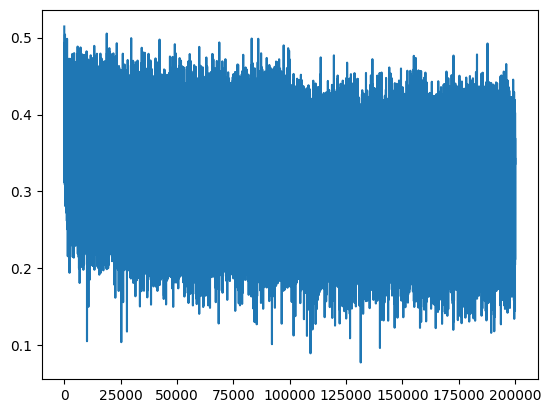

In [62]:
plt.plot(lossi)

In [63]:
@torch.no_grad() #disable grad tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embed)
    h = torch.tanh(embcat@ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.0381171703338623
val 2.10475492477417


- After matmul dist is not unit gaussian
- Std dev increases

tensor(-0.0045) tensor(1.0071)
tensor(-0.0036) tensor(1.0109)


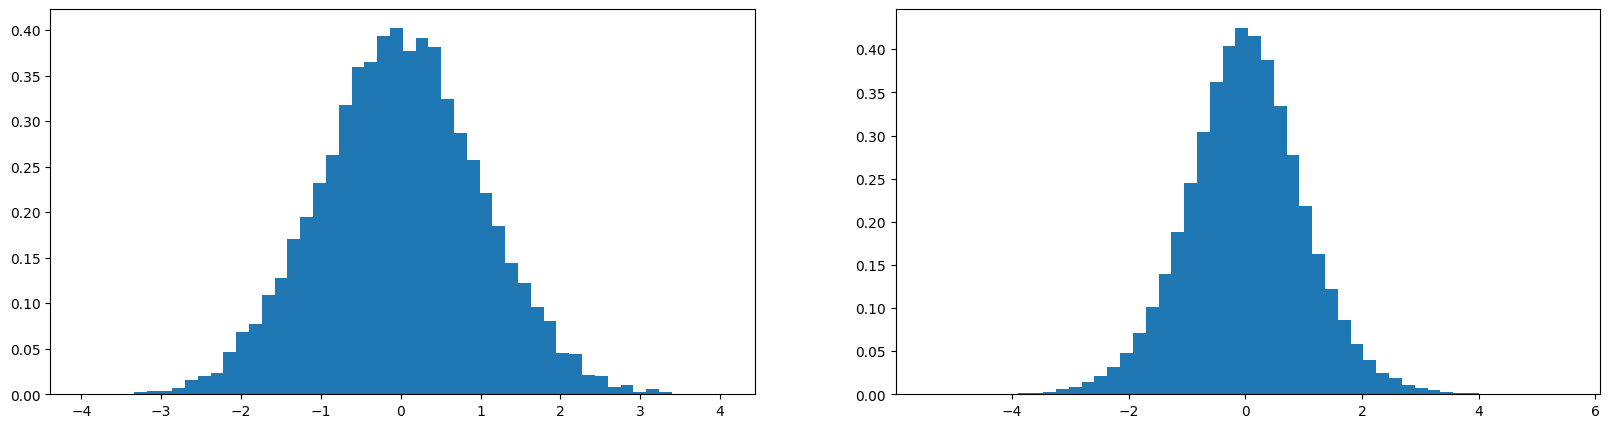

In [66]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # when normalized by sqrt of fan_in, fan_in is num of inputs
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

- Read Kaining et al on initialization

- Normalization with: gain/sqrt(fan_in)
- gain value depends on the type of activation function
- mostly use gain = 1, when batch/layer norm and better optimizers are used, this is less imp